In [1]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

# 疫情数据

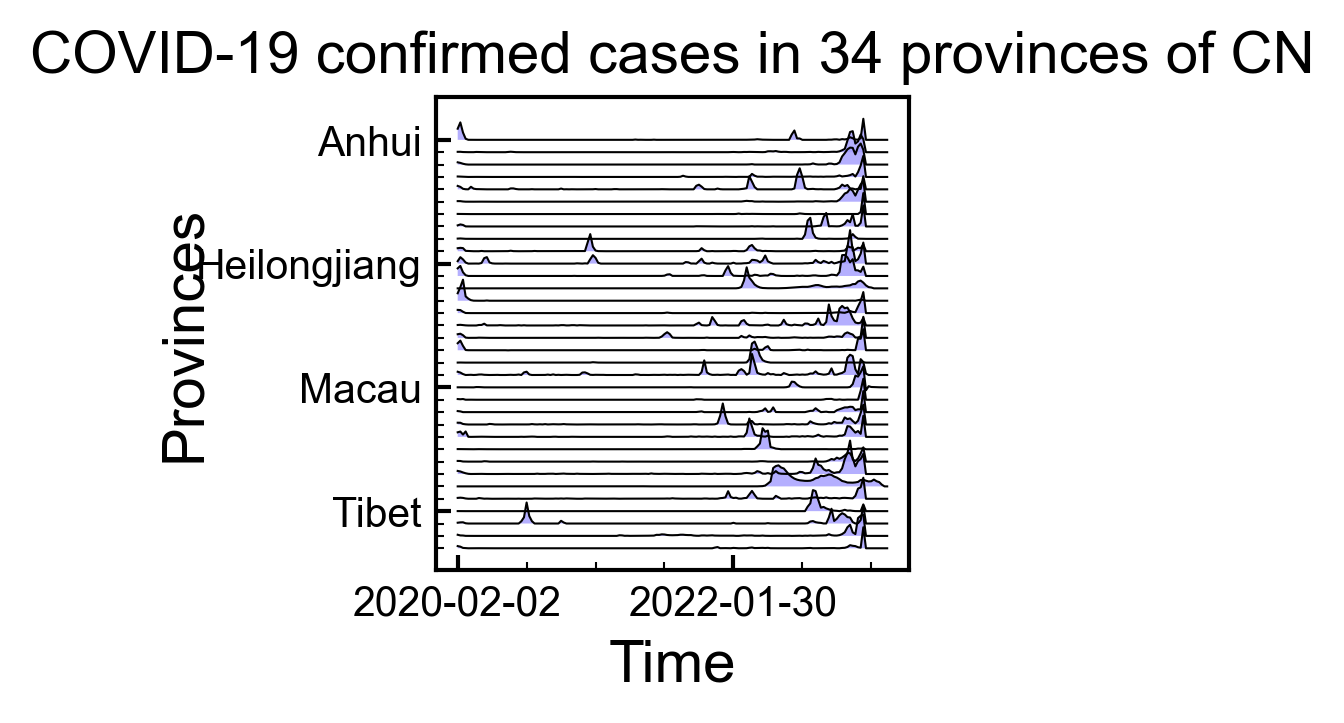

(34,) (163,) (163, 34)


In [2]:
import numpy as np
import pandas as pd

save_and_cache('https://ghp.ci/https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', '../data/epidemic/time_series_covid19_confirmed_global.csv')
df_CN = pd.read_csv('../data/epidemic/time_series_covid19_confirmed_global.csv')
df_CN = df_CN[(df_CN['Country/Region'] == 'China') | (df_CN['Country/Region'] == 'Taiwan*')]
df_CN.loc[df_CN['Country/Region'] == 'Taiwan*', 'Province/State'] = 'Taiwan'
df_CN.drop(columns=['Country/Region', 'Lat', 'Long'], inplace=True)
df_CN.set_index('Province/State', inplace=True)
df_CN.drop(index=['Unknown'], inplace=True)
df_CN.sort_index(inplace=True)

# 等间隔为 1 日
assert len(pd.to_datetime(df_CN.columns.values, format='%m/%d/%y').diff()[1:].unique()) == 1
# 汇总为 1 周的数据
df_CN.columns = pd.to_datetime(df_CN.columns, format='%m/%d/%y')
df_CN = df_CN.T.resample('W').max().T # 这里是累计确诊数，所以取最大值作为本周累计确诊数

node = df_CN.index.values # (N,)
time = pd.to_datetime(df_CN.columns, format='%m/%d/%y').astype(str).values[1:] # (T,)
case = np.diff(df_CN.values.T, axis=0) # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = len(node)
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 20 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
# axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Provinces', fontsize=fi.fontsize, labelpad=-4.0)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} provinces of CN', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inCN.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inCN.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inCN.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [109]:
node

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu',
       'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai',
       'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Taiwan',
       'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'], dtype=object)

In [110]:
len(node)

34

# OD 数据

In [3]:
import pandas as pd
from tqdm import tqdm

if os.path.exists('../data/epidemic/ODinCN.csv'):
    df = pd.read_csv('../data/epidemic/ODinCN.csv')
else:
    df_list = []
    for year in tqdm(range(2019, 2022)):
        for month in tqdm(range(1, 13)):
            try:
                # df = pd.read_parquet(f'processed/city_level_seats_and_price/2020-{month}.parquet.gz')
                # df = pd.read_parquet(f'http://rl2.yumeow.site:8000/{year}-{month}.parquet.gz')
                df = pd.read_parquet(f'/data3/yuzihan/WorkSpace/13-GraphSymbolicRegression/Data/OAG/processed/city_level_seats_and_price/{year}-{month}.parquet.gz')
                df = df[(df['Dep Country Code'].isin(['CN', 'TW', 'MO', 'HK'])) & (df['Arr Country Code'].isin(['CN', 'TW', 'MO', 'HK']))]
                city2province ={'Liupanshui': 'Guizhou', 'Hami': 'Xinjiang', 'Tianjin': 'Tianjin', 'Yuncheng': 'Shanxi', 'Jining': 'Shandong', 'Daqing': 'Heilongjiang', 'Yibin': 'Sichuan', 'Dongying': 'Shandong', 'Dalian': 'Liaoning', 'Yongzhou': 'Hunan', 'Simao': 'Yunnan', 'Shenzhen': 'Guangdong', 'Yancheng': 'Jiangsu', 'Zhuhai': 'Guangdong', 'Beihai': 'Guangxi', 'Anshun': 'Guizhou', 'Shenyang': 'Liaoning', 'Zhanjiang': 'Guangdong', 'Guangzhou': 'Guangdong', 'Zhoushan': 'Zhejiang', 'Longyan': 'Fujian', 'Yushu': 'Qinghai', 'Dali': 'Yunnan', 'Luoyang': 'Henan', 'Bijie': 'Guizhou', 'Luzhou': 'Sichuan', 'Baotou': 'Inner Mongolia', 'Hefei': 'Anhui', 'Wuhai': 'Inner Mongolia', 'Wanzhou': 'Chongqing', 'Qionghai': 'Hainan', 'Shiyan': 'Hubei', 'Zhaotong': 'Yunnan', 'Tongren': 'Guizhou', 'Huangshan': 'Anhui', 'Shihezi': 'Xinjiang', 'Baicheng': 'Jilin', 'Yantai': 'Shandong', 'Handan': 'Hebei', 'Anqing': 'Anhui', 'Jixi': 'Heilongjiang', 'Wuzhou': 'Guangxi', 'Chengde': 'Hebei', 'Wenzhou': 'Zhejiang', 'Rizhao': 'Shandong', 'Dazhou': 'Sichuan', 'Mianyang': 'Sichuan', 'Tacheng': 'Xinjiang', 'Chongqing': 'Chongqing', 'Yichang': 'Hubei', 'Dandong': 'Liaoning', 'Hechi': 'Guangxi', 'Haikou': 'Hainan', 'Lianyungang': 'Jiangsu', 'Changzhou': 'Jiangsu', 'Yueyang': 'Hunan', 'Zhangjiajie': 'Hunan', 'Fuyang': 'Anhui', 'Nanyang': 'Henan', 'Weihai': 'Shandong', 'Yangzhou': 'Jiangsu', 'Taiyuan': 'Shanxi', 'Chengdu': 'Sichuan', 'Nanjing': 'Jiangsu', 'Linfen': 'Shanxi', 'Yinchuan': 'Ningxia', 'Changchun': 'Jilin', 'Anshan': 'Liaoning', 'Tongliao': 'Inner Mongolia', 'Nanning': 'Guangxi', 'Xinyang': 'Henan', 'Nantong': 'Jiangsu', 'Xuzhou': 'Jiangsu', 'Kunming': 'Yunnan', 'Tianshui': 'Gansu', 'Huizhou': 'Guangdong', 'Quzhou': 'Zhejiang', 'Wenshan': 'Yunnan', 'Changde': 'Hunan', 'Guangyuan': 'Sichuan', 'Chifeng': 'Inner Mongolia', 'Longnan': 'Gansu', 'Xining': 'Qinghai', 'Lijiang': 'Yunnan', 'Kashi': 'Xinjiang', 'Wuxi': 'Jiangsu', 'Weifang': 'Shandong', 'Yingkou': 'Liaoning', 'Mudanjiang': 'Heilongjiang', 'Fuzhou': 'Jiangxi', 'Zhengzhou': 'Henan', 'Huaihua': 'Hunan', 'Chizhou': 'Anhui', 'Nanchong': 'Sichuan', 'Datong': 'Shanxi', 'Ganzhou': 'Jiangxi', 'Foshan': 'Guangdong', 'Lincang': 'Yunnan', 'Shaoyang': 'Hunan', 'Yichun': 'Heilongjiang', 'Hengyang': 'Hunan', 'Xinzhou': 'Shanxi', 'Shennongjia': 'Hubei', 'Baishan': 'Jilin', 'Zhongwei': 'Ningxia', 'Jinan': 'Shandong', 'Tangshan': 'Hebei', 'Jinchang': 'Gansu', 'Jingdezhen': 'Jiangxi', 'Sanming': 'Fujian', 'Songyuan': 'Jilin', 'Zhangye': 'Gansu', 'Yulin': 'Guangxi', 'Baise': 'Guangxi', 'Changsha': 'Hunan', 'Nanchang': 'Jiangxi', 'Tainan': 'Taiwan', 'Quanzhou': 'Fujian', 'Changzhi': 'Shanxi', 'Shantou': 'Guangdong', 'Qianjiang': 'Chongqing', 'Taizhou': 'Zhejiang', 'Jinzhou': 'Liaoning', 'Panzhihua': 'Sichuan', 'Shangrao': 'Jiangxi', 'Tonghua': 'Jilin', 'Ningbo': 'Zhejiang', 'Beijing': 'Beijing', 'Baoshan': 'Yunnan', 'Enshi': 'Hubei', 'Heihe': 'Heilongjiang', 'Guilin': 'Guangxi', 'Guiyang': 'Guizhou', 'Guyuan': 'Ningxia', 'Liuzhou': 'Guangxi', 'Qingdao': 'Shandong', 'Sanya': 'Hainan', 'Xiamen': 'Fujian', 'Shanghai': 'Shanghai', 'Linyi': 'Shandong', 'Wuhan': 'Hubei', 'Shijiazhuang': 'Hebei', 'Qingyang': 'Gansu', 'Hangzhou': 'Zhejiang', 'Jiayuguan': 'Gansu', 'Jiamusi': 'Heilongjiang', 'Aershan': 'Inner Mongolia', 'Wudalianchi': 'Heilongjiang', 'Alxa Right Banner': 'Inner Mongolia', 'Ulanhot': 'Inner Mongolia', 'Xinyuan': 'Xinjiang', 'Aksu': 'Xinjiang', 'Fuyun': 'Xinjiang', 'Aba Hongyuan': 'Sichuan', 'Fuyuan': 'Heilongjiang', 'Kaohsiung': 'Taiwan', 'Hailar': 'Inner Mongolia', 'Chaoyang': 'Liaoning', 'Delingha': 'Qinghai', 'Kangding': 'Sichuan', 'Erenhot': 'Inner Mongolia', 'Zhalantun': 'Inner Mongolia', 'Cangyuan': 'Yunnan', 'Hotan': 'Xinjiang', 'Ejina Banner': 'Inner Mongolia', 'Qinhaungdao': 'Hebei', 'Xichang': 'Sichuan', 'Karamay': 'Xinjiang', 'Yining': 'Xinjiang', 'Ordos': 'Inner Mongolia', 'Lanzhou Zhongchuan Apt': 'Gansu', 'Qiqihar': 'Heilongjiang', "Yan'an": 'Shaanxi', 'Xiangyang': 'Hubei', 'Altay': 'Xinjiang', 'Hualien': 'Taiwan', 'Qamdo/Changdu': 'Tibet', 'Golmud': 'Qinghai', 'Taitung': 'Taiwan', 'Korla': 'Xinjiang', 'Magong': 'Taiwan', 'Huang Ping': 'Guizhou', 'Huatugou': 'Qinghai', 'Tengchong': 'Yunnan', 'Alxa Left Banner': 'Inner Mongolia', 'Yichun (Jiangxi)': 'Jiangxi', 'LuLiang': 'Qinghai', 'Harbin': 'Heilongjiang', 'Chiayi': 'Taiwan', 'Jiuzhaigou': 'Sichuan', 'Shache': 'Xinjiang', 'Ninglang': 'Yunnan', 'Daocheng': 'Sichuan', 'Golog': 'Qinghai', 'Bole': 'Xinjiang', 'Manzhouli': 'Inner Mongolia', "Ji'an": 'Jiangxi', 'Urumqi': 'Xinjiang', 'Meixian': 'Guangdong', 'Hanzhong': 'Shaanxi', "Huai'an": 'Jiangsu', 'Bayannur': 'Inner Mongolia', 'Lhasa/Lasa': 'Tibet', "Xi'an": 'Shaanxi', 'Matsu (Beigan)': 'Fujian', 'Xingyi': 'Guizhou', 'Xilinhot': 'Inner Mongolia', 'Liping': 'Guizhou', 'Ruoqiang': 'Xinjiang', 'Jinghong': 'Yunnan', 'Jiagedaqi': 'Heilongjiang', 'Hohhot': 'Inner Mongolia', 'Mangshi': 'Yunnan', 'Jiansanjiang': 'Heilongjiang', 'Libo': 'Guizhou', 'Dunhuang': 'Gansu', 'Mohe': 'Heilongjiang', 'Zunyi (CN) 00': 'Guizhou', 'Taichung': 'Taiwan', 'Xiahe': 'Gansu', 'Nyingchi/Linzhi': 'Tibet', 'Xigaze/rikaze': 'Tibet', 'Kinmen': 'Fujian', 'Deqen': 'Yunnan', 'Matsu (Nangan)': 'Fujian', 'Yiwu': 'Zhejiang', 'Qiemo': 'Xinjiang', 'Taipei': 'Taiwan', 'Turpan': 'Xinjiang', 'Wuyishan': 'Fujian', 'Houlinguole': 'Inner Mongolia', 'Langcang': 'Yunnan', 'Ulanqab': 'Inner Mongolia', 'Kuqa': 'Xinjiang', 'Yanji': 'Jilin', 'Shiquande': 'Tibet', 'Hong Kong': 'Hong Kong', 'Macau (MO) 00': 'Macau'}
                df['Arr State Name'] = df['Arr City Name'].map(city2province)
                df['Dep State Name'] = df['Dep City Name'].map(city2province)

                df = df[['Dep State Name', 'Arr State Name', 'Total Est. Pax']]
                df = df.groupby(['Dep State Name', 'Arr State Name']).sum().reset_index()
                df['Time Series'] = f'{year}-{month:02}'
                df_list.append(df)
            except Exception as e:
                print(f'{year}-{month:02} is not available ({e})')
                continue

    df = pd.concat(df_list)
    df.columns = ['source', 'destination', 'flow', 'time']
    # mapping = {'District Of Columbia': 'District of Columbia'}
    # df['source'] = df['source'].replace(mapping)
    # df['destination'] = df['destination'].replace(mapping)
    # 汇总
    df = df.groupby(['source', 'destination'])['flow'].sum().reset_index()
    df.to_csv('../data/epidemic/ODinCN.csv', index=False)
df

,source,destination,flow
0,Anhui,Anhui,43125
1,Anhui,Beijing,1492015
2,Anhui,Chongqing,1602553
3,Anhui,Fujian,1460970
4,Anhui,Gansu,568792
...,...,...,...
1147,Zhejiang,Tianjin,2190512
1148,Zhejiang,Tibet,119229
1149,Zhejiang,Xinjiang,1623827
1150,Zhejiang,Yunnan,6851006


In [4]:
# 排除没有疫情数据的省
df = df[df['source'].isin(node) & df['destination'].isin(node)]
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
assert all(np.sort(df['source'].unique()) == node)
assert all(np.sort(df['destination'].unique()) == node)
df

,source,destination,flow
1,Anhui,Beijing,1492015
2,Anhui,Chongqing,1602553
3,Anhui,Fujian,1460970
4,Anhui,Gansu,568792
5,Anhui,Guangdong,4899952
...,...,...,...
1146,Zhejiang,Taiwan,914957
1147,Zhejiang,Tianjin,2190512
1148,Zhejiang,Tibet,119229
1149,Zhejiang,Xinjiang,1623827


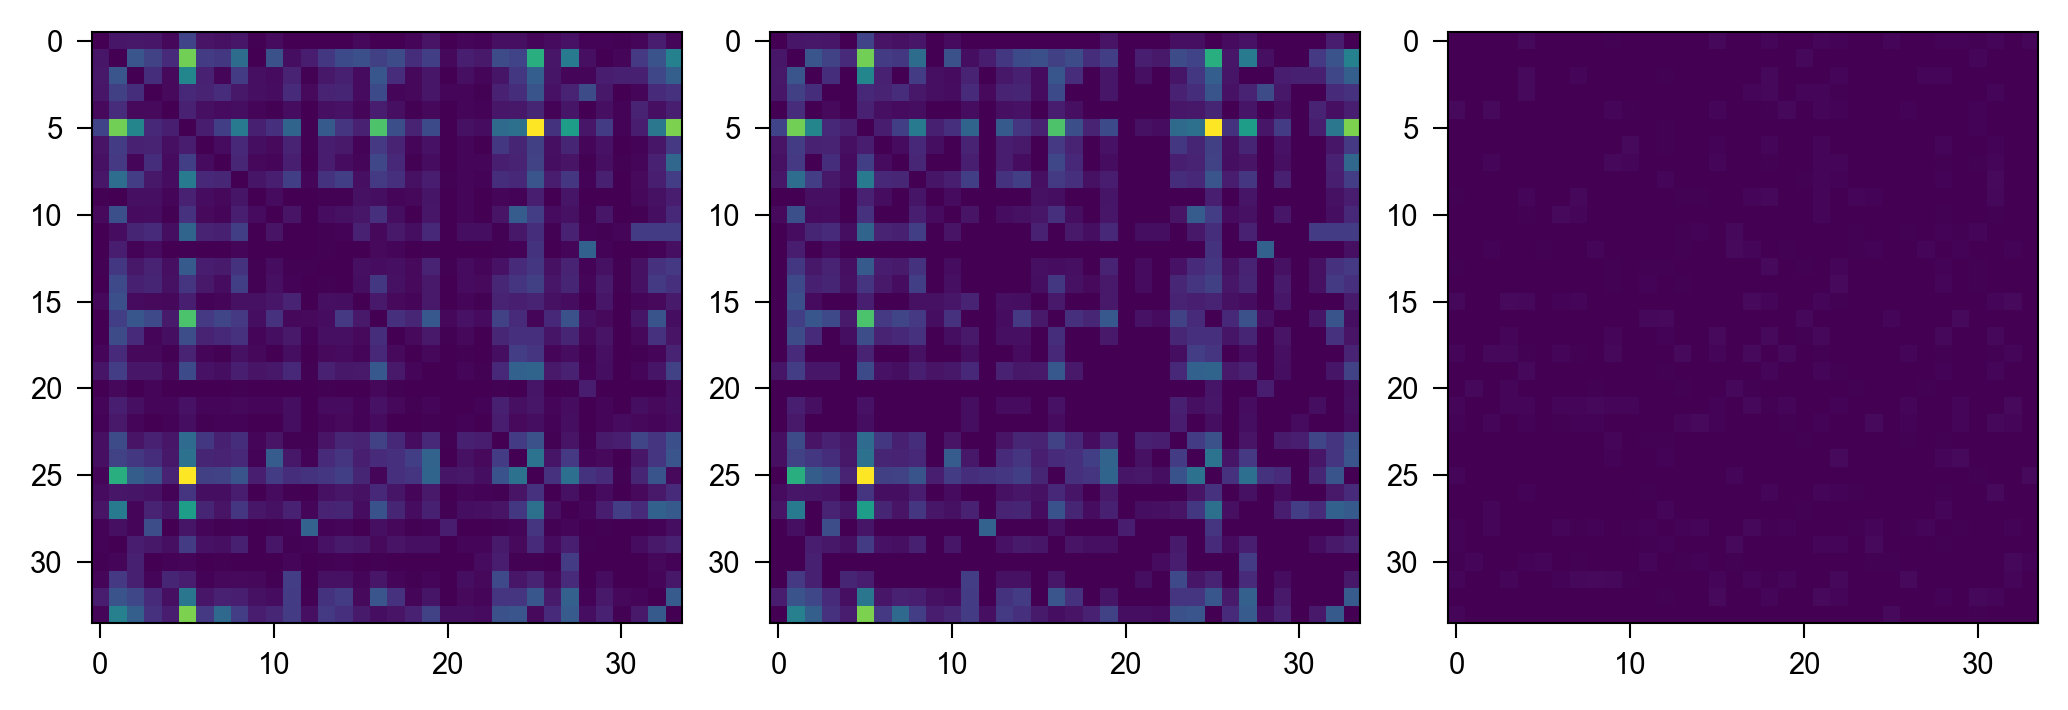

In [6]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

In [114]:
df_sparse

,source,destination,flow
195,Guangdong,Shanghai,24353273
853,Shanghai,Guangdong,24271971
203,Guangdong,Zhejiang,19582410
1123,Zhejiang,Guangdong,19576641
39,Beijing,Guangdong,19215232
...,...,...,...
411,Hong Kong,Fujian,667586
340,Heilongjiang,Anhui,648920
493,Hunan,Jilin,648107
139,Gansu,Fujian,647639


In [115]:
df

,source,destination,flow
1,Anhui,Beijing,1492015
2,Anhui,Chongqing,1602553
3,Anhui,Fujian,1460970
4,Anhui,Gansu,568792
5,Anhui,Guangdong,4899952
...,...,...,...
1146,Zhejiang,Taiwan,914957
1147,Zhejiang,Tianjin,2190512
1148,Zhejiang,Tibet,119229
1149,Zhejiang,Xinjiang,1623827


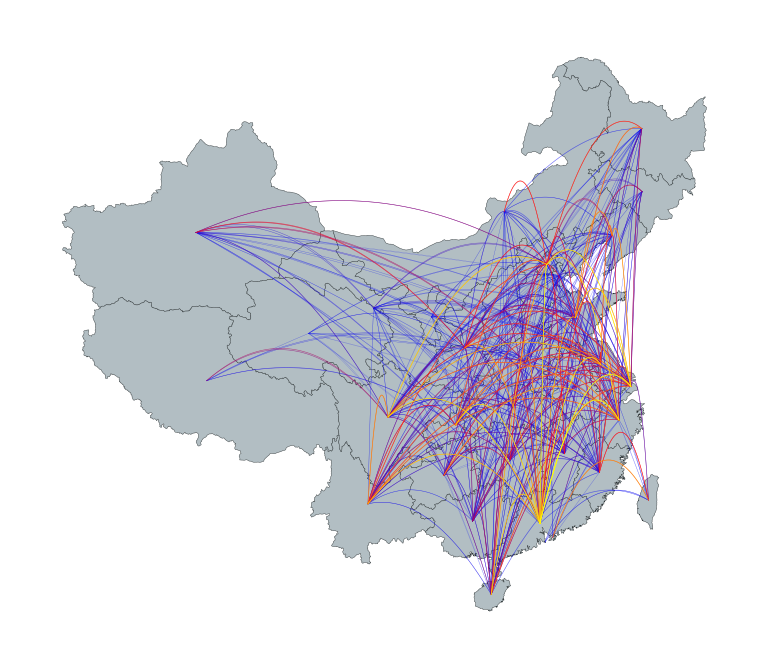

In [8]:
import geopandas as gpd
from ND2.utils.plot import get_fig, plotOD

data = df_sparse
data.columns = ['source', 'destination', 'flow']
# 下载中国省份数据
save_and_cache('https://gaohr-blog.oss-cn-beijing.aliyuncs.com/data/GIS_China/Province.zip', '../data/epidemic/Province.zip')
# gdf = gpd.read_file('../data/epidemic/Province.zip') # 手动解压一下，解除文件名乱码的错误
gdf = gpd.read_file('../data/epidemic/Province')
mapping = {'黑龙江': 'Heilongjiang', '新疆': 'Xinjiang', '山西': 'Shanxi', '宁夏': 'Ningxia', '西藏': 'Tibet', '山东': 'Shandong', '河南': 'Henan', '江苏': 'Jiangsu', '安徽': 'Anhui', '湖北': 'Hubei', '浙江': 'Zhejiang', '江西': 'Jiangxi', '湖南': 'Hunan', '云南': 'Yunnan', '贵州': 'Guizhou', '福建': 'Fujian', '广西': 'Guangxi', '广东': 'Guangdong', '海南': 'Hainan', '吉林': 'Jilin', '辽宁': 'Liaoning', '天津': 'Tianjin', '青海': 'Qinghai', '甘肃': 'Gansu', '陕西': 'Shaanxi', '内蒙古': 'Inner Mongolia', '重庆': 'Chongqing', '河北': 'Hebei', '上海': 'Shanghai', '北京': 'Beijing', '台湾': 'Taiwan', '香港': 'Hong Kong', '澳门': 'Macau', '四川': 'Sichuan'}
gdf['NAME'] = gdf['NAME'].replace(mapping)
# gdf = gdf[gdf['NAME'].isin(node)]

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
# axes[0].set_xlim(-180, -60)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinCN.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinCN.svg', transparent=True)

# 保存数据

In [9]:
import json

state2idx = {s:idx for idx, s in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(state2idx).astype(int)
df_sparse['destination_idx'] = df_sparse['destination'].map(state2idx).astype(int)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node)))
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N,)
save['time'] = time.tolist() # (T,)
save['case'] = case.tolist() # (T, N)
save['flow'] = df_sparse['flow'].values.tolist() # (E,)
save['A'] = A.tolist() # (N, N)
save['G'] = G.tolist() # (E, 2)
with open('../data/epidemic/COVID19inCN.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (34,)
time       -> (163,)
case       -> (163, 34)
flow       -> (680,)
A          -> (34, 34)
G          -> (680, 2)
